In [1]:
# TCC: APLICAÇÃO DE MACHINE LEARNING PARA APOSTAS ESPORTIVAS: uso de Regressão Logística,
#      SVM, Árvore de Decisão e Naive Bayes
#
# Aluno: João Henrique
# Orientadora: Renata Alcoforado

In [2]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [3]:
# O arquivo utilizado foi uma compilação com dados baixados do site www.football-data.co.uk, que disponibiliza...
# ... informações de diversos campeonatos ao redor do mundo
# Por meio do Excel foram retirados os jogos em que estavam faltando dados de quaisquer variáveis de interesse...
# ...para o estudo


# Legenda das variáveis:

# Country = País do campeonato
# League = Nome da liga
# Season = Temporada
# Date = Data do jogo
# Time = Hora do jogo
# Home = Time da casa
# Away = Time visitante
# HG = Gols marcados pelo time da casa
# AG = Gols marcados pelo time visitante
# Res = Resultado do jogo (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
# PH = Odd (probablidade) de vitória do time da casa pela Pinnacle (casa de apostas)
# PD = Odd (probablidade) de empate pela Pinnacle (casa de apostas)
# PA = Odd (probablidade) de vitória do time visitante pela Pinnacle (casa de apostas)
# MaxH = Odd (probablidade) máxima de vitória do time da casa
# MaxD = Odd (probablidade) máxima de empate
# MaxA = Odd (probablidade) máxima de vitória do time visitante
# AvgH = Odd (probablidade) média de vitória do time da casa
# AvgD = Odd (probablidade) média de empate
# AvgA = Odd (probablidade) média de vitória do time visitante

# Lendo o arquivo BRA5anos.csv
data = pd.read_csv('BRA5anos.csv', delimiter = ',')

# Visualizando a base de dados:
display(data.head())

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2017,13/05/2017,20:00,Flamengo RJ,Atletico-MG,1,1,D,1.91,3.70,4.34,1.95,3.70,4.75,1.87,3.49,4.04
1,Brazil,Serie A,2017,13/05/2017,23:00,Corinthians,Chapecoense-SC,1,1,D,1.37,4.85,10.91,1.37,5.00,12.40,1.34,4.55,9.79
2,Brazil,Serie A,2017,14/05/2017,15:00,Fluminense,Santos,3,2,H,2.01,3.75,3.83,2.01,3.75,4.33,1.92,3.43,3.90
3,Brazil,Serie A,2017,14/05/2017,20:00,Avai,Vitoria,0,0,D,2.39,3.31,3.29,2.45,3.31,3.40,2.32,3.11,3.15
4,Brazil,Serie A,2017,14/05/2017,20:00,Bahia,Atletico-PR,6,2,H,1.73,3.61,5.91,1.79,3.61,6.00,1.72,3.37,5.25


In [4]:
# Criando a coluna com o identificador do jogo (Game_id)

data = pd.DataFrame(data)
data = data.reset_index()
data = data.rename(columns = {"index": "Game_id"})
data["Game_id"] = data.index + 1


# Alterando os resultados de string (D = empate, H = vitória do time da casa, A = vitória do time visitante), para
# int (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(data)):
    if data["Res"][i] == "D":
        data.at[i,"Res"] = "0"
    if data["Res"][i] == "H":
        data.at[i,"Res"] = "1"
    if data["Res"][i] == "A":
        data.at[i,"Res"] = "2"

data["Res"] = data["Res"].astype(str).astype(int)

# Verificando as 5 primeiras linhas do arquivo após os primeiros ajustes
display(data.head())

,Game_id,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,1,Brazil,Serie A,2017,13/05/2017,20:00,Flamengo RJ,Atletico-MG,1,1,0,1.91,3.70,4.34,1.95,3.70,4.75,1.87,3.49,4.04
1,2,Brazil,Serie A,2017,13/05/2017,23:00,Corinthians,Chapecoense-SC,1,1,0,1.37,4.85,10.91,1.37,5.00,12.40,1.34,4.55,9.79
2,3,Brazil,Serie A,2017,14/05/2017,15:00,Fluminense,Santos,3,2,1,2.01,3.75,3.83,2.01,3.75,4.33,1.92,3.43,3.90
3,4,Brazil,Serie A,2017,14/05/2017,20:00,Avai,Vitoria,0,0,0,2.39,3.31,3.29,2.45,3.31,3.40,2.32,3.11,3.15
4,5,Brazil,Serie A,2017,14/05/2017,20:00,Bahia,Atletico-PR,6,2,1,1.73,3.61,5.91,1.79,3.61,6.00,1.72,3.37,5.25


Total de jogos:  1900
Total de colunas:  20
Total de jogos ganhos em casa:  898
Total de jogos ganhos pelo visitante:  470
Total de jogos empatados:  532
Percentual de jogos ganhos em casa: 47.26%


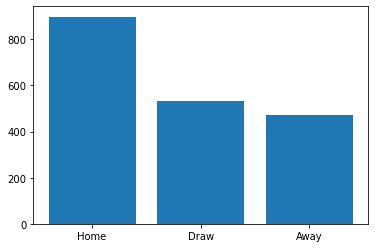

In [5]:
# Explorando a base de dados de dos campeonatos de 2017 a 2021 (últimas 5 temporadas completas)

matches = data.shape[0]
features = data.shape[1]

home_win = len(data[data.Res==1])
away_win = len(data[data.Res==2])
draw = len(data[data.Res==0])
val = [home_win, draw, away_win]

win_rate = (float(home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Draw', 'Away'))
plt.show()

In [6]:
# Separando as features e as labels

features = data[['PH', 'PD', 'PA']]
labels = data['Res']

print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

Features
     PH    PD     PA
0  1.91  3.70   4.34
1  1.37  4.85  10.91
2  2.01  3.75   3.83
3  2.39  3.31   3.29
4  1.73  3.61   5.91
Labels
0    0
1    0
2    1
3    0
4    1
Name: Res, dtype: int32


In [7]:
# Normalizando os dados de entrada (features)

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

Features:  (1900, 3)
[[0.05       0.11946447 0.11220542]
 [0.01746988 0.23789907 0.34329933]
 [0.0560241  0.1246138  0.09426662]
 ...
 [0.18855422 0.1338826  0.02497362]
 [0.06204819 0.05149331 0.11185368]
 [0.04036145 0.11328527 0.14526908]]


In [8]:
# Separação de treino e teste, feita manualmente para manter a ordem cronológica, uma vez que...
# ... temos informação temporal.
# Treino [:1520]     representa 80% dos dados
# Teste [1520:1710]      representa 10% dos dados
# Previsão [1710:1900]     representa 10% dos dados


X_train = features_scale[:1520]
X_test = features_scale[1520:1710]
y_train = labels[:1520]
y_test = labels[1520:1710]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1520 1520
190 190


In [9]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 44.21%
F1 Score: 44.21%


In [10]:
# Rodando o modelo de Support Vector Machine (SVM)

clf_SVM = SVC()
clf_SVM.fit(X_train, y_train)
pred = clf_SVM.predict(X_test)

svm_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('SVM')
print('')
print('Acurácia: {:.2f}%'.format(svm_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

SVM

Acurácia: 43.16%
F1 Score: 43.16%


In [11]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 42.63%
F1 Score: 41.67%


In [12]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'micro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 43.68%
F1 Score: 43.68%


In [13]:
# Executando a previsão pelo método de maior acurácia (Regressão Logística)

previsao = features_scale[1710:]

game_id_full = data['Game_id']
game_id_prev = game_id_full[1710:]

res_full = data['Res']
res_prev = res_full[1710:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'Game_id': game_id_prev})

print(df)

      Real  Previsão  Game_id
1710     0         1     1711
1711     1         1     1712
1712     2         2     1713
1713     2         2     1714
1714     1         1     1715
...    ...       ...      ...
1895     1         1     1896
1896     1         1     1897
1897     1         2     1898
1898     0         1     1899
1899     0         1     1900

[190 rows x 3 columns]


<AxesSubplot:xlabel='Previsão', ylabel='Real'>

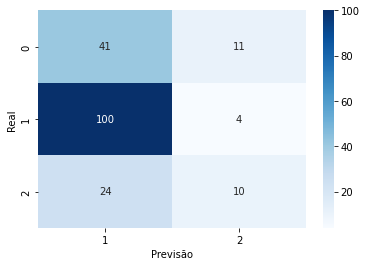

In [14]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')